# MOVIE STUDIO ANALYSIS

<img src="images/moviedog.jpg" style="width:100%; height:auto;">

## Business understanding

Our company have decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office.
We must then translate the findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

* Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

## Data understanding

we will be using the following datasets:
1. `rt.reviews.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
2. `rt.movie_info.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
3. `im.db` from [IMDB](https://www.imdb.com/)
4. `bom.movie_gross.csv` from [BOXOFFICE MOJO](https://www.boxofficemojo.com/)
5. `tn.movie_budgets.csv` from [NUMBERS](https://www.the-numbers.com/)

### Importing libraries

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

### Loading Data sets

In [2]:
# loading datasets

# reviews dataset
file_path = 'data/rt.reviews.tsv'

try:
    review_df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f"Error parsing file: {e}")

#Loading Movie_Info
movie_info_df = pd.read_csv('data/rt.movie_info.tsv', sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')

f'''
# bom.movie_gross.csv
path = 'data/bom.movie_gross.csv'
movie_gross_df = pd.read_csv(path)
'''

# im.dbsqlite, we load only the 2 tables that are needed for the analysis. 
conn = sqlite3.connect('data/im.db')
q = '''
SELECT *
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_ID = movie_ratings.movie_id
'''
imdb_df = pd.read_sql(q, conn)

# Loading 'The Numbers' Dataset
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)


## Data understanding

### 1. review_df

## DATA CLEANING

#### 1.1. Merging review_df and Movie_info_df

In [3]:
#merge the two dfs
merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')

#### 1.2 Dropping columns not used

In [4]:
# columns to drop
columns_to_drop =['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio', 'currency', 'box_office']

merged_df = merged_df.drop(columns_to_drop, axis=1)

#### 1.3 Changing column names for rating_x (star_rating) and rating_y(MPAA_rating)

In [5]:
merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'}, inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


#### 1.4 checking and Dealing with missing values

In [6]:
merged_df.isna().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
runtime           838
dtype: int64

#### 1.5 Standardizing star_rating

In [7]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
# merged_df

#### 1.5.1 fill missing standardized rating with mean

In [8]:
# fill standardized_rating with mean

merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_8328\3497875837.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)


In [9]:
# drop rows with missing values on columns `MPAA_rating` and `genre`
merged_df = merged_df.dropna(subset=['MPAA_rating', 'genre'])

In [10]:
# Drop the star_rating column because we have standardized rating

merged_df = merged_df.drop('star_rating', axis=1)

#### 1.6 checking and dropping duplicates

In [11]:
# checking duplicates
duplicate_rows = merged_df[merged_df.duplicated()]

#dropping duplicates
merged_df = merged_df.drop_duplicates()

In [12]:
merged_df.isna().sum()

id                        0
fresh                     0
date                      0
MPAA_rating               0
genre                     0
director               4105
theater_date            954
dvd_date                954
runtime                 471
standardized_rating       0
dtype: int64

#### 1.7 handling missing values for director, theatre date, dvd_date, runtime

In [13]:
# 1. Drop rows with missing values in specific columns
merged_df.dropna(subset=['theater_date', 'dvd_date'], inplace=True)

# 2. Fill with specific values
merged_df['director'].fillna('Unknown', inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_8328\3538672782.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['director'].fillna('Unknown', inplace=True)


#### 1.8 extract minutes in the runtime dataset

In [14]:
# extract minutes in the runtime dataset
merged_df['runtime'] = merged_df['runtime'].str.extract('(\d+)').astype(float)

# fill the missing runtime values with the mean
merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_8328\3809561258.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39453 entries, 0 to 54431
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39453 non-null  int64  
 1   fresh                39453 non-null  object 
 2   date                 39453 non-null  object 
 3   MPAA_rating          39453 non-null  object 
 4   genre                39453 non-null  object 
 5   director             39453 non-null  object 
 6   theater_date         39453 non-null  object 
 7   dvd_date             39453 non-null  object 
 8   runtime              39453 non-null  float64
 9   standardized_rating  39453 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 3.3+ MB


In [16]:
merged_df.head()

,id,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime,standardized_rating
0,3,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.000000
1,3,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
2,3,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
3,3,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
4,3,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708


### 2. movie_budgets_df 

In [17]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### 2.1 checking for null values

In [18]:
movie_budgets_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### 2.2 checking for duplicates

In [19]:
#  checking duplicates

duplicated_rows = movie_budgets_df[movie_budgets_df.duplicated()]
duplicated_rows

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


#### 2.3 standardizing date time and removing the dolar sign from the `production_budget` and other cash columns

In [20]:
# Convert 'release_date' to datetime
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])

movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


### 3. imdb data set

In [21]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


#### 3.1 checking for duplicates

In [22]:
# checking duplicates

dup_rows = imdb_df[imdb_df.duplicated]
dup_rows

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes


#### 3.2 checking and dealing with null

In [23]:
# drop null values on runtime and genres rows

imdb_df = imdb_df.dropna(subset = ['runtime_minutes', 'genres'], )

In [24]:
imdb_df.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
movie_id           0
averagerating      0
numvotes           0
dtype: int64

### Visualization

#### 1. Univariate

##### plot `fresh` from `merge_df` distribution

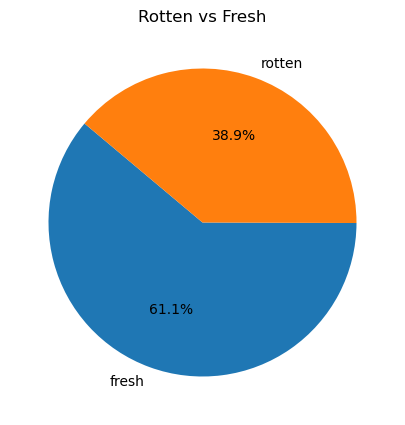

In [25]:
frequencies = merged_df['fresh'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 5))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
plt.title('Rotten vs Fresh')
plt.show()

#### plot of cost distribution 

c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


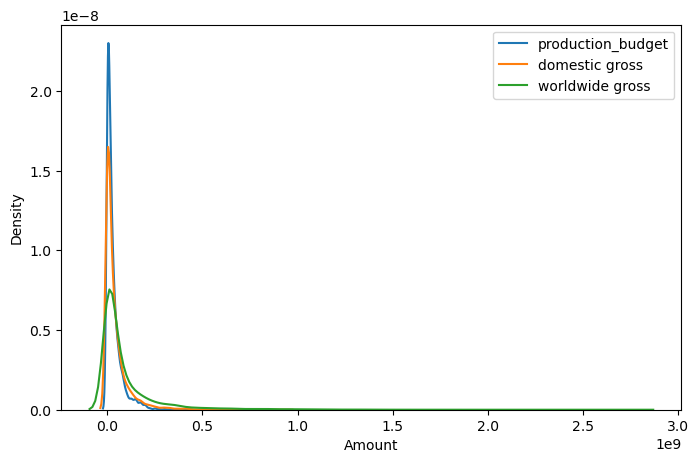

In [41]:
plt.figure(figsize=(8, 5))
sns.kdeplot(movie_budgets_df['production_budget'], label='production_budget')
sns.kdeplot(movie_budgets_df['domestic_gross'], label='domestic gross')
sns.kdeplot(movie_budgets_df['worldwide_gross'], label='worldwide gross')
plt.xlabel('Amount')
plt.legend()
plt.show()

###  `imdb` data analysis

In [31]:
imdb_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43


#### checking genre combinations

In [28]:
imdb_df['genres'].unique()

array(['Action,Crime,Drama', 'Biography,Drama', 'Drama',
       'Comedy,Drama,Fantasy', 'Adventure,Animation,Comedy', 'History',
       'Documentary', 'Animation,Drama,History', 'Drama,Mystery',
       'Action,Animation,Comedy', 'Biography,Comedy,Drama',
       'Action,Drama', 'Documentary,History', 'Sci-Fi', 'Comedy',
       'Thriller', 'Adventure,Animation,Sci-Fi', 'Drama,Horror',
       'Drama,Mystery,Thriller', 'Drama,Family',
       'Adventure,Comedy,Romance', 'Comedy,Drama',
       'Adventure,Drama,Romance', 'Biography', 'Horror',
       'Adventure,Comedy,Drama', 'Drama,Sci-Fi,Thriller', 'Action',
       'Comedy,Drama,Romance', 'Action,Adventure,Sci-Fi', 'Crime,Drama',
       'Comedy,Family', 'Adventure', 'Drama,History,War',
       'Action,Thriller', 'Comedy,Crime', 'Crime,Drama,Thriller',
       'Action,Sci-Fi,Thriller', 'Fantasy', 'Drama,Mystery,Sci-Fi',
       'Biography,Drama,History', 'Action,Comedy,Crime',
       'Action,Adventure,Thriller', 'Horror,Mystery,Thriller',
    

#### Normalize and tokenize genre strings to analyze the combinations

In [32]:
# Normalize genre strings - making them of same of same category, lowecase
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Expand genres into separate columns
genres_expanded = imdb_df['genres_list'].explode().unique()
for genre in genres_expanded:
    imdb_df[genre] = imdb_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Drop the intermediate columns
df = imdb_df.drop(columns=['genres', 'genres_list'])

df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,movie_id,averagerating,numvotes,action,crime,...,war,music,sport,western,musical,news,reality-tv,game-show,adult,short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,tt0063540,7.0,77,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,tt0066787,7.2,43,0,0,...,0,0,0,0,0,0,0,0,0,0


#### genre frequency distribution

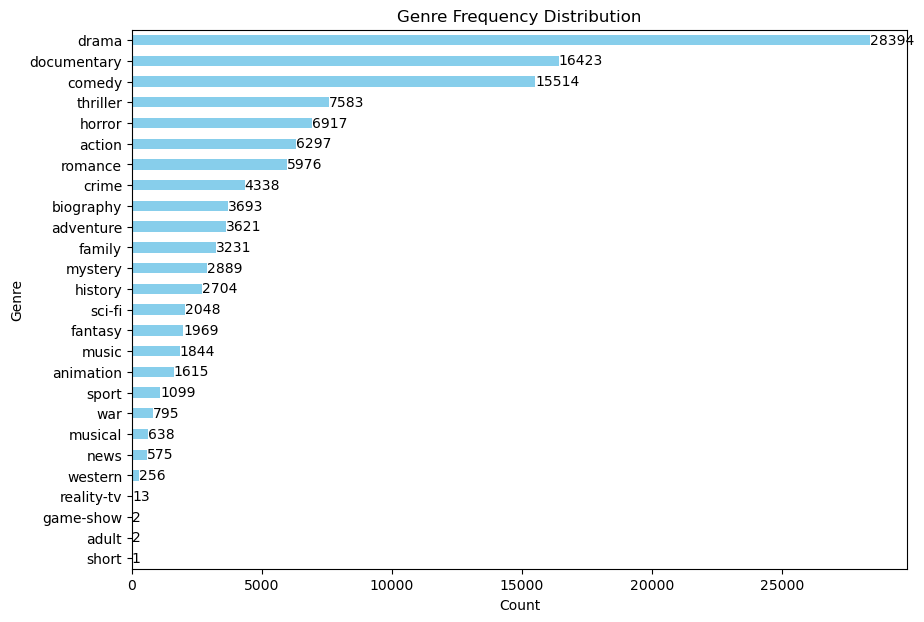

In [34]:
#Frequency count

# Count the frequency of each genre
genre_counts = df[genres_expanded].sum()

# Plot the distribution
plt.figure(figsize=(10, 7))
ax = genre_counts.sort_values().plot(kind='barh', color='skyblue')

# Add count labels next to each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, int(width), 
            ha='left', va='center', color='black')

plt.title('Genre Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


#### Genre combinations co-occurrence - heatmap

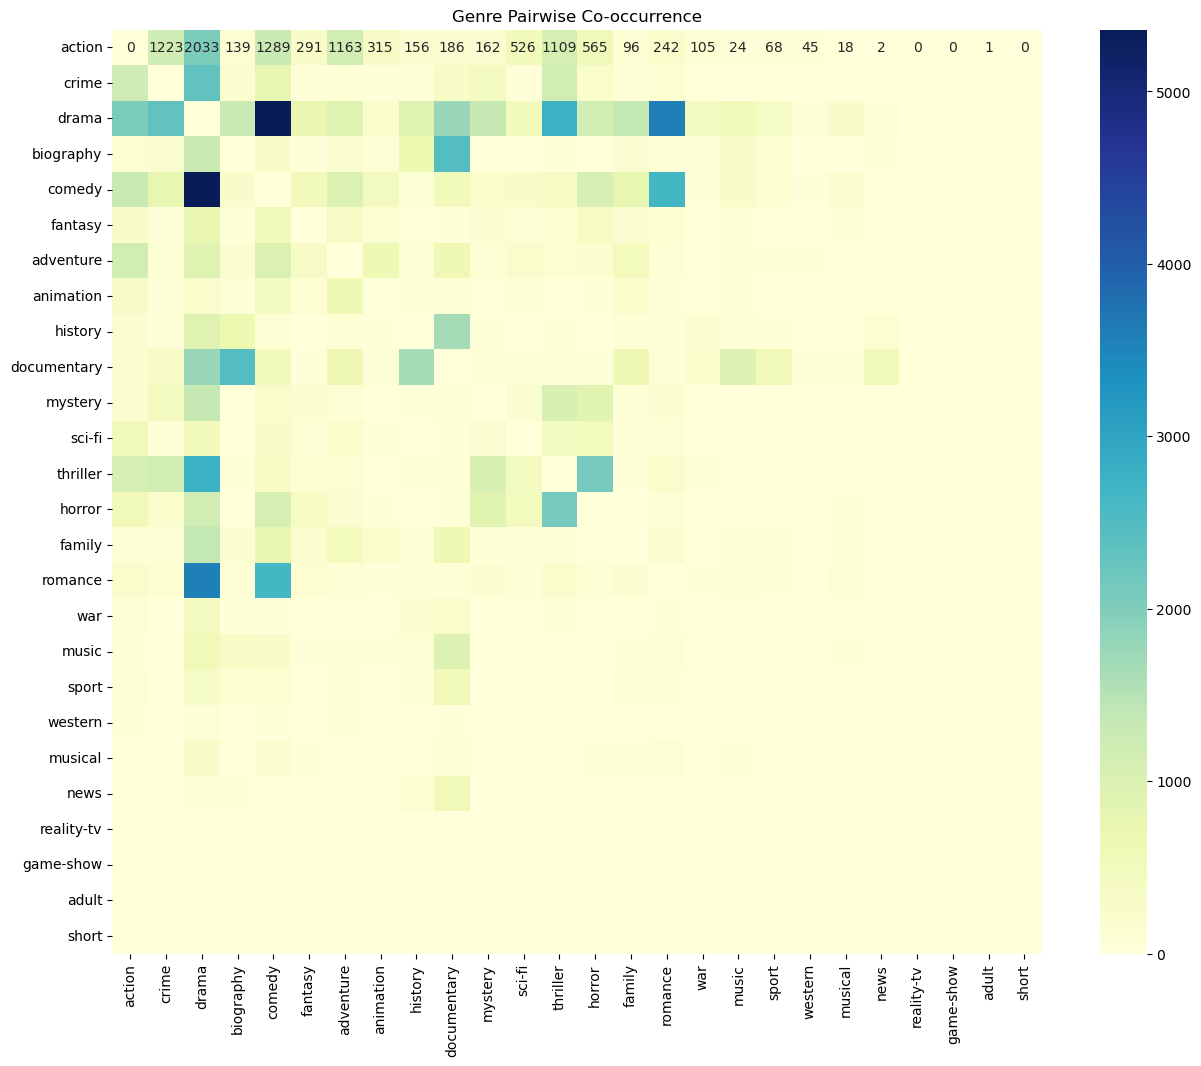

In [48]:
# Create a DataFrame for pairwise genre combinations
from itertools import combinations

# Calculate pairwise genre co-occurrence
genre_pairs = pd.DataFrame(
    index=genres_expanded,
    columns=genres_expanded,
    data=0
)

for genre1, genre2 in combinations(genres_expanded, 2):
    genre_pairs.loc[genre1, genre2] = ((df[genre1] & df[genre2]).sum())
    genre_pairs.loc[genre2, genre1] = genre_pairs.loc[genre1, genre2]

# Plot the pairwise co-occurrence
plt.figure(figsize=(15, 12))
sns.heatmap(genre_pairs, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre Pairwise Co-occurrence')
plt.show()


#### genre occurence and combinations count

In [51]:
# Normalize genre strings
#imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
#imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Create a DataFrame to store genre combinations
genre_combinations = pd.DataFrame(columns=['Combination', 'Count'])

# Generate genre combinations for each movie and count occurrences
combination_counts = {}

for _, row in imdb_df.iterrows():
    genres = sorted(row['genres_list'])  # Sort genres to ensure order consistency
    for r in range(1, len(genres) + 1):
        for combo in combinations(genres, r):
            combo_str = ' & '.join(combo)
            if combo_str in combination_counts:
                combination_counts[combo_str] += 1
            else:
                combination_counts[combo_str] = 1

# Convert the combination counts dictionary to a DataFrame
genre_combinations = pd.DataFrame(list(combination_counts.items()), columns=['Combination', 'Count'])

# Sort by Count in descending order
result_table = genre_combinations.sort_values(by='Count', ascending=False)

# Print the sorted table
print("Genre Combination Counts:")
print(result_table)

Genre Combination Counts:
                          Combination  Count
2                               drama  28394
22                        documentary  16423
9                              comedy  15514
36                           thriller   7583
40                             horror   6917
..                                ...    ...
798             drama & war & western      1
800        adventure & music & sci-fi      1
802        biography & family & sport      1
804  action & animation & documentary      1
966     documentary & family & sci-fi      1

[967 rows x 2 columns]


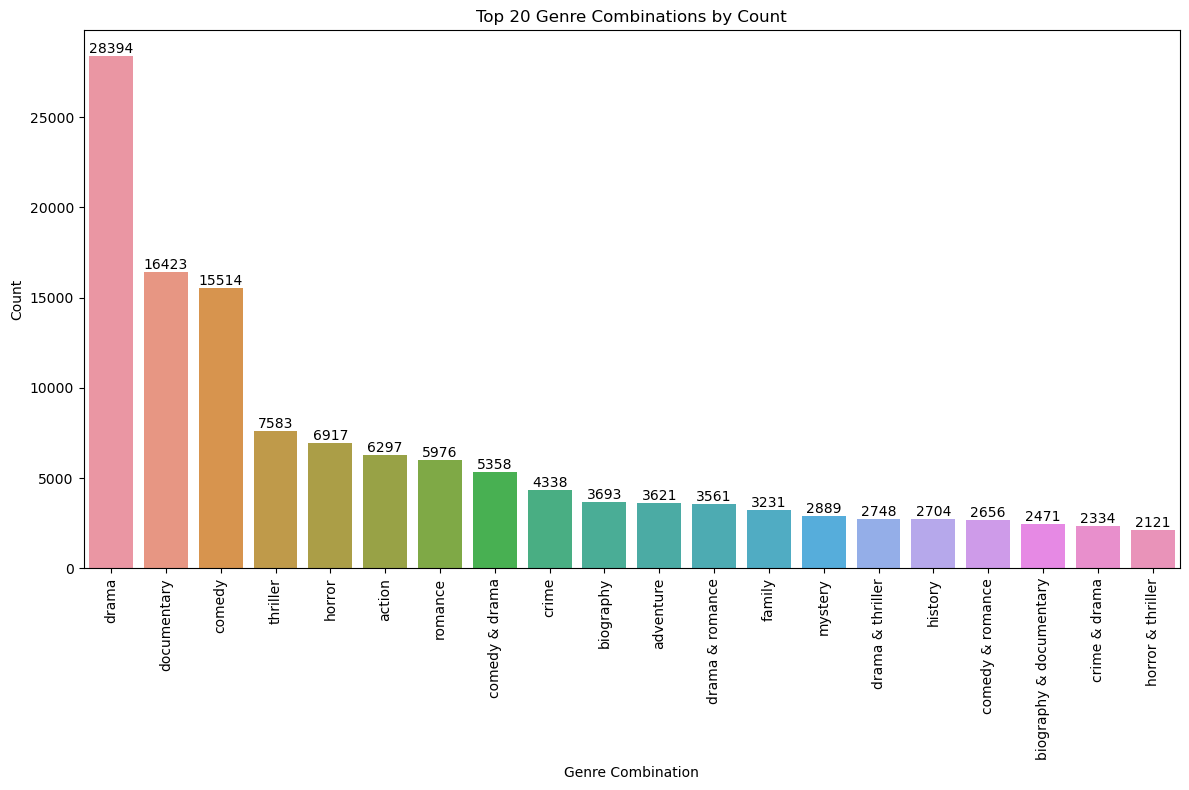

In [56]:
# Create DataFrame and select top 20 rows
result = pd.DataFrame(result_table)
result = result.head(20)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=result['Combination'], y=result['Count'])

# Adding annotations (count values) on top of each bar
for index, value in enumerate(result['Count']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Top 20 Genre Combinations by Count')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.tight_layout()
plt.show()